# Traditional Machine Learning Classifiers for Fake News Detetcion

In this notebook we shall train an SVM and Logistic Regression model and benchmark their performance in detcting fake news.

## Install Libraries

The PyTorch Geometric Library has the UPFD dataset we need. We request your patience it takes around **30 mins** to install the library and it's dependencies.

In [ ]:
!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html
!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-+.html
  Created wheel for torch-scatter: filename=torch_scatter-2.0.9-cp37-cp37m-linux_x86_64.whl size=274491 sha256=c5f907b4146515bd51ee99c8b2eb317573e1f54b238dfec2362c4886ecc8ad13
  Stored in directory: /root/.cache/pip/wheels/dd/57/a3/42ea193b77378ce634eb9454c9bc1e3163f3b482a35cdee4d1
Successfully built torch-scatter
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-+.html
     |████████████████████████████████| 2.1 MB 20.1 MB/s 


In [ ]:
# Load the UPFD Dataset
from torch_geometric.datasets import UPFD

# Load libraries for data preprocessing 
import numpy as np
import matplotlib.pyplot as plt
import torch

# Loading our classic models from sklearn
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# Libraries for metrics and benchmarking
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score

## Load and Investigate Datsets

The UPFD dataset was created from the Gossipcop and Politifact datasets. As this datset was originally created for GNNs, the dataloader loads graphs as the input data. To make it compatible with linear models, we shall only use the data present in the **Root Node** of the graphs as this node contains the text from the news article in question.

\
NOTE: We have set feature to spacy to ensure we only use the embedding of the article content. The alternative profile/content would include the 10 features about the user's twitter account, irrelavant for the linear model.

In [ ]:
# Set the type of feature vector, uncomment the one you want to use
#feature = "spacy"
feature = "bert"

In [ ]:
# Loading graphs from Gossippcop
train_data_g = UPFD(root=".", name="gossipcop", feature=feature, split="train")
test_data_g = UPFD(root=".", name="gossipcop", feature=feature, split="test")
val_data_g = UPFD(root=".", name="gossipcop", feature=feature, split="val")
print("Gossippcop Train Samples: ", len(train_data_g))
print("Gossippcop Test Samples: ", len(test_data_g))
print("Gossippcop Vaidation Samples: ", len(val_data_g))

Gossippcop Train Samples:  1092
Gossippcop Test Samples:  3826
Gossippcop Vaidation Samples:  546


In [ ]:
# Loading graphs from Politifact
train_data_p = UPFD(root=".", name="politifact", feature=feature, split="train")
test_data_p = UPFD(root=".", name="politifact", feature=feature, split="test")
val_data_p = UPFD(root=".", name="politifact", feature=feature, split="val")
print("Politifact Train Samples: ", len(train_data_p))
print("Politifact Test Samples: ", len(test_data_p))
print("Politifact Validation Samples: ", len(val_data_p))

# Changed ratio of sets such that train:val:test is 7:1:2
combined = test_data_p+train_data_p+val_data_p
train_data_pol,val_data_pol,test_data_pol = torch.utils.data.random_split(combined, [220,31,63],generator=torch.Generator().manual_seed(42))
print("New Politifact Train Samples: ", len(train_data_pol))
print("New Politifact Test Samples: ", len(test_data_pol))
print("New Politifact Vaidation Samples: ", len(val_data_pol))

In [ ]:
# Loading the first graph object to check the structure
train_data_p[0]

Data(x=[72, 768], edge_index=[2, 71], y=[1])

In [ ]:
# Exploring the feature vectors of the graph nodes
train_data_p[0].x

tensor([[ 0.4983,  0.1415,  0.3561,  ..., -0.4199,  0.2446,  1.0323],
        [-0.0111, -0.0716, -0.1016,  ...,  0.4221, -0.1941,  0.2685],
        [ 0.0332,  0.1159,  0.0657,  ...,  0.3730, -0.0025,  0.5887],
        ...,
        [ 0.0062,  0.0708,  0.0217,  ...,  0.3643, -0.0376,  0.5008],
        [ 0.0360,  0.0502,  0.0446,  ...,  0.4044, -0.0616,  0.4972],
        [ 0.0360,  0.0502,  0.0446,  ...,  0.4044, -0.0616,  0.4972]])

In [ ]:
# Great the root node would be the first element of the above tensor
len(train_data_p[0].x[0])

768

### Voila we now know how to successfully extract the spacy/bert embedding of the news article. We can now directly feed this to our SVM and LogReg models.

\
NOTE: The graph structure in both datasets are the same. Also the spacy embedding should be of length 300 wheras bert would be of length 768.

## Pre-Processing the Graph Data

Writing a function to help extract the sapcy embeddings of the news articles from the user propogation graphs.

In [ ]:
def extractNews(train_data, test_data, val_data):
  x_train = np.empty(len(train_data), dtype=object)
  y_train = np.empty(len(train_data), dtype=int)

  x_test = np.empty(len(test_data), dtype=object)
  y_test = np.empty(len(test_data), dtype=int)

  x_val = np.empty(len(val_data), dtype=object)
  y_val = np.empty(len(val_data), dtype=int)

  for i in range(len(train_data)):
    x_train[i] = train_data[i].x[0]
    y_train[i] = train_data[i].y

  for i in range(len(test_data)):
    x_test[i] = test_data[i].x[0]
    y_test[i] = test_data[i].y

  for i in range(len(val_data)):
    x_val[i] = val_data[i].x[0]
    y_val[i] = val_data[i].y

  # Remember to detach the tensors!
  x_train = [t.cpu().detach().numpy() for t in x_train]
  x_test = [t.cpu().detach().numpy() for t in x_test]
  x_val = [t.cpu().detach().numpy() for t in x_val]

  return x_train, y_train, x_test, y_test, x_val, y_val

In [ ]:
# Processed Gossipcop Data
x_train_g, y_train_g, x_test_g, y_test_g, x_val_g, y_val_g = extractNews(train_data_g, test_data_g, val_data_g)

# Processed Politifact Data
x_train_p, y_train_p, x_test_p, y_test_p, x_val_p, y_val_p = extractNews(train_data_p, test_data_p, val_data_p)

# Processed Politifact Data with new split
x_train_pol, y_train_pol, x_test_pol, y_test_pol, x_val_pol, y_val_pol = extractNews(train_data_pol, test_data_pol, val_data_pol)

## Support Vector Machine Classifier


In [ ]:
def SVM(x_train, y_train, x_test, y_test):
  clf = svm.SVC(kernel='linear')
  clf.fit(x_train, y_train)

  y_pred_svm = clf.predict(x_test)

  print("Accuracy Score:", accuracy_score(y_test, y_pred_svm), '\n')

  target_names = ['Fake', 'Real']
  print(classification_report(y_test, y_pred_svm, target_names=target_names))
  print("Number of mislabeled points out of a total %d points : %d" % (len(x_test), (y_test != y_pred_svm).sum()))


  # Displaying Confusion Matrix
  titles_options = [
      ("Confusion matrix, without normalization", None),
      ("Normalized confusion matrix", "true"),
  ]
  for title, normalize in titles_options:
      disp = ConfusionMatrixDisplay.from_estimator(
          clf,
          x_test,
          y_test,
          #display_labels=class_names,
          cmap=plt.cm.Blues,
          normalize=normalize,
      )
      disp.ax_.set_title(title)

      print(title)
      print(disp.confusion_matrix)
      print()

  plt.show()
  return

Accuracy Score: 0.721118661787768 

              precision    recall  f1-score   support

        Fake       0.71      0.75      0.73      1910
        Real       0.74      0.69      0.71      1916

    accuracy                           0.72      3826
   macro avg       0.72      0.72      0.72      3826
weighted avg       0.72      0.72      0.72      3826

Number of mislabeled points out of a total 3826 points : 1067
Confusion matrix, without normalization
[[1433  477]
 [ 590 1326]]

Normalized confusion matrix
[[0.75026178 0.24973822]
 [0.30793319 0.69206681]]



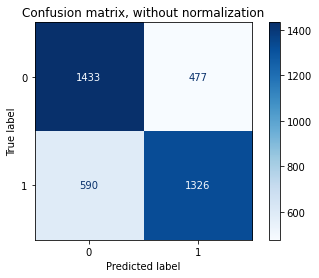

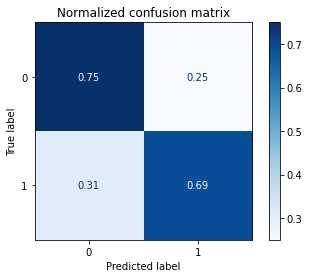

In [ ]:
# SVM on Gossipcop Data
SVM(x_train_g, y_train_g, x_test_g, y_test_g)

Accuracy Score: 0.7279142707788814 

              precision    recall  f1-score   support

        Fake       0.71      0.77      0.74      1910
        Real       0.75      0.69      0.72      1916

    accuracy                           0.73      3826
   macro avg       0.73      0.73      0.73      3826
weighted avg       0.73      0.73      0.73      3826

Number of mislabeled points out of a total 3826 points : 1041
Confusion matrix, without normalization
[[1466  444]
 [ 597 1319]]

Normalized confusion matrix
[[0.76753927 0.23246073]
 [0.31158664 0.68841336]]



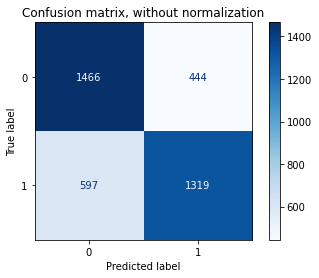

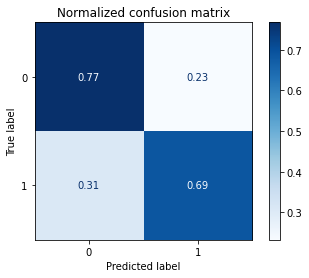

In [ ]:
# With val+train for building the model
x_train = x_train_g + x_val_g
y_train = np.concatenate((y_train_g, y_val_g))
SVM(x_train, y_train, x_test_g, y_test_g)

Accuracy Score: 0.8099547511312217 

              precision    recall  f1-score   support

        Fake       0.78      0.86      0.82       108
        Real       0.85      0.76      0.80       113

    accuracy                           0.81       221
   macro avg       0.81      0.81      0.81       221
weighted avg       0.81      0.81      0.81       221

Number of mislabeled points out of a total 221 points : 42
Confusion matrix, without normalization
[[93 15]
 [27 86]]

Normalized confusion matrix
[[0.86111111 0.13888889]
 [0.23893805 0.76106195]]



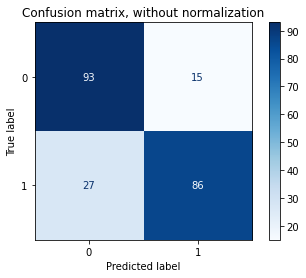

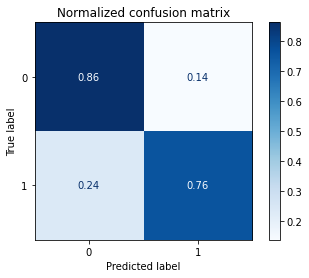

In [ ]:
# SVM on Politifact Data
SVM(x_train_p, y_train_p, x_test_p, y_test_p)

Accuracy Score: 0.832579185520362 

              precision    recall  f1-score   support

        Fake       0.82      0.84      0.83       108
        Real       0.85      0.82      0.83       113

    accuracy                           0.83       221
   macro avg       0.83      0.83      0.83       221
weighted avg       0.83      0.83      0.83       221

Number of mislabeled points out of a total 221 points : 37
Confusion matrix, without normalization
[[91 17]
 [20 93]]

Normalized confusion matrix
[[0.84259259 0.15740741]
 [0.17699115 0.82300885]]



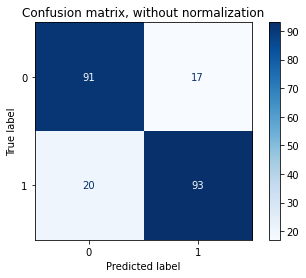

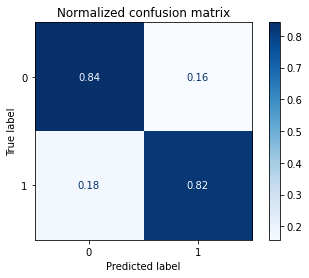

In [ ]:
# With val+train for building the model
x_train = x_train_p + x_val_p
y_train = np.concatenate((y_train_p, y_val_p))
SVM(x_train, y_train, x_test_p, y_test_p)

Accuracy Score: 0.8253968253968254 

              precision    recall  f1-score   support

        Fake       0.81      0.83      0.82        30
        Real       0.84      0.82      0.83        33

    accuracy                           0.83        63
   macro avg       0.83      0.83      0.83        63
weighted avg       0.83      0.83      0.83        63

Number of mislabeled points out of a total 63 points : 11
Confusion matrix, without normalization
[[25  5]
 [ 6 27]]

Normalized confusion matrix
[[0.83333333 0.16666667]
 [0.18181818 0.81818182]]



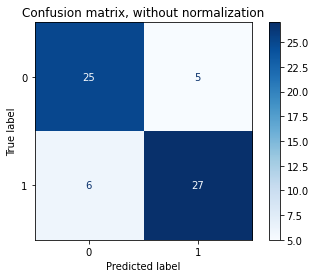

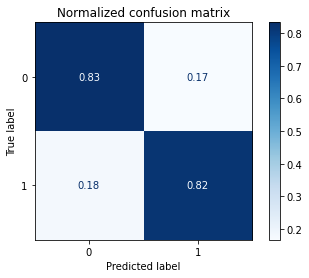

In [ ]:
# SVM on Polifact Dataset with new split
x_train = x_train_pol + x_val_pol
y_train = np.concatenate((y_train_pol, y_val_pol))
SVM(x_train, y_train, x_test_pol, y_test_pol)

## Multivariate Logistic Regression

We need to scale the data first to ensure the model converges.

In [ ]:
def MLR(x_train, y_train, x_test, y_test):
  logreg = LogisticRegression(solver='liblinear').fit(x_train, y_train)

  y_pred_logreg = logreg.predict(x_test)

  print("Accuracy Score:", accuracy_score(y_test, y_pred_logreg), '\n')
  target_names = ['Fake', 'Real']
  print(classification_report(y_test, y_pred_logreg, target_names=target_names))
  print("Number of mislabeled points out of a total %d points : %d" % (len(x_test), (y_test != y_pred_logreg).sum()))

In [ ]:
# Multivariate Logistic Reggression on Gossipcop Data
MLR(x_train_g, y_train_g, x_test_g, y_test_g)

Accuracy Score: 0.7365394668060637 

              precision    recall  f1-score   support

        Fake       0.71      0.79      0.75      1910
        Real       0.76      0.69      0.72      1916

    accuracy                           0.74      3826
   macro avg       0.74      0.74      0.74      3826
weighted avg       0.74      0.74      0.74      3826

Number of mislabeled points out of a total 3826 points : 1008


In [ ]:
x_train = x_train_g + x_val_g
y_train = np.concatenate((y_train_g, y_val_g))
MLR(x_train, y_train, x_test_g, y_test_g)

Accuracy Score: 0.7341871406168322 

              precision    recall  f1-score   support

        Fake       0.71      0.78      0.75      1910
        Real       0.76      0.69      0.72      1916

    accuracy                           0.73      3826
   macro avg       0.74      0.73      0.73      3826
weighted avg       0.74      0.73      0.73      3826

Number of mislabeled points out of a total 3826 points : 1017


In [ ]:
# Multivariate Logistic Reggression on Politifact Data
MLR(x_train_p, y_train_p, x_test_p, y_test_p)

Accuracy Score: 0.8235294117647058 

              precision    recall  f1-score   support

        Fake       0.78      0.90      0.83       108
        Real       0.89      0.75      0.81       113

    accuracy                           0.82       221
   macro avg       0.83      0.83      0.82       221
weighted avg       0.83      0.82      0.82       221

Number of mislabeled points out of a total 221 points : 39


In [ ]:
x_train = x_train_p + x_val_p
y_train = np.concatenate((y_train_p, y_val_p))
MLR(x_train, y_train, x_test_p, y_test_p)

Accuracy Score: 0.8461538461538461 

              precision    recall  f1-score   support

        Fake       0.81      0.90      0.85       108
        Real       0.89      0.80      0.84       113

    accuracy                           0.85       221
   macro avg       0.85      0.85      0.85       221
weighted avg       0.85      0.85      0.85       221

Number of mislabeled points out of a total 221 points : 34


In [ ]:
# Multivariate Logistic regression on Politifact Dataset with new split
x_train = x_train_pol + x_val_pol
y_train = np.concatenate((y_train_pol, y_val_pol))
MLR(x_train, y_train, x_test_pol, y_test_pol)

Accuracy Score: 0.8412698412698413 

              precision    recall  f1-score   support

        Fake       0.78      0.93      0.85        30
        Real       0.93      0.76      0.83        33

    accuracy                           0.84        63
   macro avg       0.85      0.85      0.84        63
weighted avg       0.86      0.84      0.84        63

Number of mislabeled points out of a total 63 points : 10


## Extra - Naive Bayes Classifier

A rather simple classifier that wasn't included in the report. 

In [ ]:
def NBC(x_train, y_train, x_test, y_test):
  gnb = GaussianNB().fit(x_train, y_train)
  y_pred_gnb = gnb.predict(x_test)

  print("Accuracy Score:", accuracy_score(y_test, y_pred_gnb), '\n')
  target_names = ['Fake', 'Real']
  print(classification_report(y_test, y_pred_gnb, target_names=target_names))
  print("Number of mislabeled points out of a total %d points : %d" % (len(x_test), (y_test != y_pred_gnb).sum()))

In [ ]:
# Naive Bayes on Gossipcop Data
NBC(x_train_g, y_train_g, x_test_g, y_test_g)

Accuracy Score: 0.6445373758494511 

              precision    recall  f1-score   support

        Fake       0.67      0.57      0.61      1910
        Real       0.63      0.72      0.67      1916

    accuracy                           0.64      3826
   macro avg       0.65      0.64      0.64      3826
weighted avg       0.65      0.64      0.64      3826

Number of mislabeled points out of a total 3826 points : 1360


In [ ]:
x_train = x_train_g + x_val_g
y_train = np.concatenate((y_train_g, y_val_g))
NBC(x_train, y_train, x_test_g, y_test_g)

Accuracy Score: 0.652639832723471 

              precision    recall  f1-score   support

        Fake       0.68      0.58      0.63      1910
        Real       0.63      0.72      0.68      1916

    accuracy                           0.65      3826
   macro avg       0.66      0.65      0.65      3826
weighted avg       0.66      0.65      0.65      3826

Number of mislabeled points out of a total 3826 points : 1329


In [ ]:
# Naive Bayes on Politifact Data
NBC(x_train_p, y_train_p, x_test_p, y_test_p)

Accuracy Score: 0.6787330316742082 

              precision    recall  f1-score   support

        Fake       0.68      0.64      0.66       108
        Real       0.68      0.72      0.70       113

    accuracy                           0.68       221
   macro avg       0.68      0.68      0.68       221
weighted avg       0.68      0.68      0.68       221

Number of mislabeled points out of a total 221 points : 71


In [ ]:
x_train = x_train_p + x_val_p
y_train = np.concatenate((y_train_p, y_val_p))
NBC(x_train, y_train, x_test_p, y_test_p)

Accuracy Score: 0.6877828054298643 

              precision    recall  f1-score   support

        Fake       0.70      0.63      0.66       108
        Real       0.68      0.74      0.71       113

    accuracy                           0.69       221
   macro avg       0.69      0.69      0.69       221
weighted avg       0.69      0.69      0.69       221

Number of mislabeled points out of a total 221 points : 69


In [ ]:
# Naive Bayes on Politifact Data with new split
x_train = x_train_pol + x_val_pol
y_train = np.concatenate((y_train_pol, y_val_pol))
NBC(x_train, y_train, x_test_pol, y_test_pol)

Accuracy Score: 0.8095238095238095 

              precision    recall  f1-score   support

        Fake       0.76      0.87      0.81        30
        Real       0.86      0.76      0.81        33

    accuracy                           0.81        63
   macro avg       0.81      0.81      0.81        63
weighted avg       0.82      0.81      0.81        63

Number of mislabeled points out of a total 63 points : 12


## Simple Neural Network

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Dense
!pip install keras-tuner
import keras_tuner as kt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 20.1 MB/s 
     |████████████████████████████████| 1.6 MB 32.0 MB/s 


In [ ]:
def valid_callback(name):
  return [tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='min', patience=3)]

In [ ]:
from keras import backend as K
def f1(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
def tuneModel(hp):
  model = Sequential([
        Dense(units=hp.Int("num_neurons_1", min_value=32, max_value=256, step=4), activation='relu'),
        Dropout(rate=0.5),
        Dense(units=hp.Int("num_neurons_2", min_value=32, max_value=256, step=4), activation='relu'),
        Dropout(rate=0.5),
        Dense(units=hp.Int("num_neurons_3", min_value=32, max_value=256, step=4), activation='relu'),
        Dropout(rate=0.5),
        Dense(units=hp.Int("num_neurons_4", min_value=32, max_value=256, step=4), activation='relu'),
        Dropout(rate=0.5),
        Dense(2, activation='sigmoid')
    ])


  learning_rate=hp.Float("learning_rate", min_value=1e-4, max_value=2e-1, sampling='log')
  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

  model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy',f1])
  
  return model

In [ ]:
tuner = kt.RandomSearch(
    hypermodel=tuneModel,
    objective=kt.Objective("val_loss", direction="min"),
    max_trials=20,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)

### Politifact (Split 20:10:70)

In [ ]:
tuner.search(np.array(x_train_p), np.array(y_train_p), epochs=100, validation_data=(np.array(x_val_p), np.array(y_val_p)), callbacks=[valid_callback('model')])


Trial 20 Complete [00h 00m 02s]
val_loss: 0.691455066204071

Best val_loss So Far: 0.6474995017051697
Total elapsed time: 00h 00m 44s


In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('num_neurons_1')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 176 and the optimal learning rate for the optimizer
is 0.009432969328113518.



In [ ]:
print(best_hps.get('num_neurons_1'),best_hps.get('num_neurons_2'),best_hps.get('num_neurons_3'),best_hps.get('num_neurons_4'),best_hps.get('learning_rate'))

176 172 176 44 0.009432969328113518


In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(np.array(x_train_p), np.array(y_train_p), validation_data=(np.array(x_val_p),np.array(y_val_p)),epochs=50)

val_cross_entropy_per_epoch = history.history['val_loss']
best_epoch = val_cross_entropy_per_epoch.index(min(val_cross_entropy_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
2/2 [==============================] - 1s 216ms/step - loss: 2.2623 - accuracy: 0.4516 - f1: 0.6109 - val_loss: 0.6799 - val_accuracy: 0.5806 - val_f1: 0.9000
Epoch 2/50
2/2 [==============================] - 0s 37ms/step - loss: 1.0924 - accuracy: 0.4677 - f1: 0.5625 - val_loss: 0.6907 - val_accuracy: 0.5161 - val_f1: 0.9114
Epoch 3/50
2/2 [==============================] - 0s 39ms/step - loss: 1.0905 - accuracy: 0.5645 - f1: 0.5798 - val_loss: 0.8091 - val_accuracy: 0.4194 - val_f1: 0.0000e+00
Epoch 4/50
2/2 [==============================] - 0s 51ms/step - loss: 0.8912 - accuracy: 0.5323 - f1: 0.7548 - val_loss: 0.7000 - val_accuracy: 0.4194 - val_f1: 0.0000e+00
Epoch 5/50
2/2 [==============================] - 0s 36ms/step - loss: 1.0571 - accuracy: 0.5161 - f1: 0.4762 - val_loss: 0.6847 - val_accuracy: 0.6774 - val_f1: 0.0000e+00
Epoch 6/50
2/2 [==============================] - 0s 65ms/step - loss: 0.8666 - accuracy: 0.5161 - f1: 0.4113 - val_loss: 0.7251 - val_accurac

In [ ]:
x_train_p_combined = np.concatenate((np.array(x_train_p), np.array(x_val_p)), axis=0)
y_train_p_combined = np.concatenate((np.array(y_train_p), np.array(y_val_p)), axis=0)


In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)
history = hypermodel.fit(x_train_p_combined, y_train_p_combined,epochs=best_epoch)

Epoch 1/38
3/3 [==============================] - 1s 18ms/step - loss: 1.0379 - accuracy: 0.6452 - f1: 0.6315
Epoch 2/38
3/3 [==============================] - 0s 18ms/step - loss: 1.9448 - accuracy: 0.5269 - f1: 0.6386
Epoch 3/38
3/3 [==============================] - 0s 18ms/step - loss: 1.2783 - accuracy: 0.4946 - f1: 0.6986
Epoch 4/38
3/3 [==============================] - 0s 21ms/step - loss: 0.9575 - accuracy: 0.5161 - f1: 0.7380
Epoch 5/38
3/3 [==============================] - 0s 18ms/step - loss: 1.0547 - accuracy: 0.5161 - f1: 0.6461
Epoch 6/38
3/3 [==============================] - 0s 18ms/step - loss: 0.7736 - accuracy: 0.5699 - f1: 0.7266
Epoch 7/38
3/3 [==============================] - 0s 18ms/step - loss: 0.7689 - accuracy: 0.4839 - f1: 0.6705
Epoch 8/38
3/3 [==============================] - 0s 21ms/step - loss: 0.7112 - accuracy: 0.5376 - f1: 0.6656
Epoch 9/38
3/3 [==============================] - 0s 18ms/step - loss: 0.7431 - accuracy: 0.4516 - f1: 0.7348
Epoch 10/3

In [ ]:
hypermodel.evaluate(x_train_p_combined,y_train_p_combined)

3/3 [==============================] - 0s 4ms/step - loss: 0.1029 - accuracy: 0.9570 - f1: 0.6424


[0.10293744504451752, 0.9569892287254333, 0.642395555973053]

In [ ]:
hypermodel.evaluate(np.array(x_test_p),np.array(y_test_p))

7/7 [==============================] - 0s 2ms/step - loss: 0.9122 - accuracy: 0.7828 - f1: 0.6643


[0.9122011065483093, 0.7828054428100586, 0.6642504334449768]

### Politifact (Custom Split 70:10:20) 

In [ ]:
tuner.search(np.array(x_train_p), np.array(y_train_p), epochs=100, validation_data=(np.array(x_val_p), np.array(y_val_p)), callbacks=[valid_callback('model')])


Trial 20 Complete [00h 00m 02s]
val_loss: 0.6830078363418579

Best val_loss So Far: 0.5844074487686157
Total elapsed time: 00h 01m 00s


In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('num_neurons_1')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 188 and the optimal learning rate for the optimizer
is 0.015792327714011775.



In [ ]:
print(best_hps.get('num_neurons_1'),best_hps.get('num_neurons_2'),best_hps.get('num_neurons_3'),best_hps.get('num_neurons_4'),best_hps.get('learning_rate'))

188 148 112 112 0.015792327714011775


In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(np.array(x_train_p), np.array(y_train_p), validation_data=(np.array(x_val_p),np.array(y_val_p)),epochs=50)

val_cross_entropy_per_epoch = history.history['val_loss']
best_epoch = val_cross_entropy_per_epoch.index(min(val_cross_entropy_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
2/2 [==============================] - 4s 396ms/step - loss: 2.3824 - accuracy: 0.5000 - f1: 0.6590 - val_loss: 1.0355 - val_accuracy: 0.5806 - val_f1: 0.7347
Epoch 2/50
2/2 [==============================] - 0s 41ms/step - loss: 2.4859 - accuracy: 0.4839 - f1: 0.6973 - val_loss: 0.7170 - val_accuracy: 0.4194 - val_f1: 0.8065
Epoch 3/50
2/2 [==============================] - 0s 45ms/step - loss: 1.0668 - accuracy: 0.5806 - f1: 0.5882 - val_loss: 0.6925 - val_accuracy: 0.5806 - val_f1: 0.8861
Epoch 4/50
2/2 [==============================] - 0s 45ms/step - loss: 1.8373 - accuracy: 0.4194 - f1: 0.5833 - val_loss: 0.6857 - val_accuracy: 0.5484 - val_f1: 0.5714
Epoch 5/50
2/2 [==============================] - 0s 43ms/step - loss: 0.9505 - accuracy: 0.5161 - f1: 0.4802 - val_loss: 0.7784 - val_accuracy: 0.4194 - val_f1: 0.7347
Epoch 6/50
2/2 [==============================] - 0s 43ms/step - loss: 1.0191 - accuracy: 0.5161 - f1: 0.5584 - val_loss: 0.7486 - val_accuracy: 0.4194 - 

In [ ]:
x_train_p_combined = np.concatenate((np.array(x_train_p), np.array(x_val_p)), axis=0)
y_train_p_combined = np.concatenate((np.array(y_train_p), np.array(y_val_p)), axis=0)


In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)
history = hypermodel.fit(x_train_p_combined, y_train_p_combined,epochs=best_epoch)

Epoch 1/18
3/3 [==============================] - 1s 28ms/step - loss: 1.8431 - accuracy: 0.5269 - f1: 0.6945
Epoch 2/18
3/3 [==============================] - 0s 15ms/step - loss: 2.5371 - accuracy: 0.5699 - f1: 0.6486
Epoch 3/18
3/3 [==============================] - 0s 14ms/step - loss: 1.0228 - accuracy: 0.6129 - f1: 0.6786
Epoch 4/18
3/3 [==============================] - 0s 14ms/step - loss: 0.9815 - accuracy: 0.4839 - f1: 0.6585
Epoch 5/18
3/3 [==============================] - 0s 15ms/step - loss: 0.7482 - accuracy: 0.5054 - f1: 0.6229
Epoch 6/18
3/3 [==============================] - 0s 14ms/step - loss: 0.6823 - accuracy: 0.5484 - f1: 0.6893
Epoch 7/18
3/3 [==============================] - 0s 14ms/step - loss: 0.6811 - accuracy: 0.6022 - f1: 0.6362
Epoch 8/18
3/3 [==============================] - 0s 14ms/step - loss: 0.7229 - accuracy: 0.6129 - f1: 0.6063
Epoch 9/18
3/3 [==============================] - 0s 18ms/step - loss: 0.6267 - accuracy: 0.5914 - f1: 0.5915
Epoch 10/1

In [ ]:
hypermodel.evaluate(x_train_p_combined,y_train_p_combined)

3/3 [==============================] - 0s 6ms/step - loss: 0.3946 - accuracy: 0.8387 - f1: 0.6424


[0.39461418986320496, 0.8387096524238586, 0.642395555973053]

In [ ]:
hypermodel.evaluate(np.array(x_test_p),np.array(y_test_p))

7/7 [==============================] - 0s 5ms/step - loss: 0.7443 - accuracy: 0.7376 - f1: 0.6457


[0.7442671656608582, 0.7375565767288208, 0.6457352042198181]

### Gossipcop

In [ ]:
tuner = kt.RandomSearch(
    hypermodel=tuneModel,
    objective=kt.Objective("val_loss", direction="min"),
    max_trials=20,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)
tuner.search(np.array(x_train_g), np.array(y_train_g), epochs=100, validation_data=(np.array(x_val_g), np.array(y_val_g)), callbacks=[valid_callback('model')])


Trial 20 Complete [00h 00m 08s]
val_loss: 0.6935113072395325

Best val_loss So Far: 0.4920743703842163
Total elapsed time: 00h 02m 06s


In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('num_neurons_1')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 140 and the optimal learning rate for the optimizer
is 0.00039172756021875113.



In [ ]:
print(best_hps.get('num_neurons_1'),best_hps.get('num_neurons_2'),best_hps.get('num_neurons_3'),best_hps.get('num_neurons_4'),best_hps.get('learning_rate'))

140 136 204 116 0.00039172756021875113


In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(np.array(x_train_g), np.array(y_train_g), validation_data=(np.array(x_val_g),np.array(y_val_g)),epochs=50)

val_cross_entropy_loss_per_epoch = history.history['val_loss']
best_epoch = val_cross_entropy_loss_per_epoch.index(min(val_cross_entropy_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
35/35 [==============================] - 2s 17ms/step - loss: 0.8150 - accuracy: 0.5009 - f1: 0.7068 - val_loss: 0.6903 - val_accuracy: 0.4963 - val_f1: 0.8088
Epoch 2/50
35/35 [==============================] - 0s 8ms/step - loss: 0.7148 - accuracy: 0.5183 - f1: 0.7237 - val_loss: 0.6856 - val_accuracy: 0.5824 - val_f1: 0.7796
Epoch 3/50
35/35 [==============================] - 0s 9ms/step - loss: 0.7103 - accuracy: 0.5147 - f1: 0.7011 - val_loss: 0.6818 - val_accuracy: 0.6209 - val_f1: 0.7569
Epoch 4/50
35/35 [==============================] - 0s 8ms/step - loss: 0.6931 - accuracy: 0.5687 - f1: 0.7069 - val_loss: 0.6756 - val_accuracy: 0.6300 - val_f1: 0.6661
Epoch 5/50
35/35 [==============================] - 0s 9ms/step - loss: 0.6915 - accuracy: 0.5238 - f1: 0.7196 - val_loss: 0.6752 - val_accuracy: 0.6520 - val_f1: 0.7313
Epoch 6/50
35/35 [==============================] - 0s 9ms/step - loss: 0.6789 - accuracy: 0.5687 - f1: 0.7251 - val_loss: 0.6709 - val_accuracy: 0.6

In [ ]:
x_train_g_combined = np.concatenate((np.array(x_train_g), np.array(x_val_g)), axis=0)
y_train_g_combined = np.concatenate((np.array(y_train_g), np.array(y_val_g)), axis=0)

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model with the best epoch
history = hypermodel.fit(x_train_g_combined,y_train_g_combined,epochs=best_epoch)


Epoch 1/32
52/52 [==============================] - 1s 6ms/step - loss: 0.7851 - accuracy: 0.5317 - f1: 0.6449
Epoch 2/32
52/52 [==============================] - 0s 6ms/step - loss: 0.7119 - accuracy: 0.5122 - f1: 0.6267
Epoch 3/32
52/52 [==============================] - 0s 6ms/step - loss: 0.6987 - accuracy: 0.5104 - f1: 0.5995
Epoch 4/32
52/52 [==============================] - 0s 6ms/step - loss: 0.6958 - accuracy: 0.5232 - f1: 0.5785
Epoch 5/32
52/52 [==============================] - 0s 6ms/step - loss: 0.6835 - accuracy: 0.5421 - f1: 0.6354
Epoch 6/32
52/52 [==============================] - 0s 6ms/step - loss: 0.6724 - accuracy: 0.5836 - f1: 0.6165
Epoch 7/32
52/52 [==============================] - 0s 6ms/step - loss: 0.6345 - accuracy: 0.6441 - f1: 0.6053
Epoch 8/32
52/52 [==============================] - 0s 6ms/step - loss: 0.6363 - accuracy: 0.6422 - f1: 0.6114
Epoch 9/32
52/52 [==============================] - 0s 7ms/step - loss: 0.6149 - accuracy: 0.6722 - f1: 0.6106
E

In [ ]:
hypermodel.evaluate(np.array(x_val_g),np.array(y_val_g))

18/18 [==============================] - 0s 3ms/step - loss: 0.3744 - accuracy: 0.8388 - f1: 0.6715


[0.374373197555542, 0.8388278484344482, 0.6715036630630493]

In [ ]:
hypermodel.evaluate(np.array(x_test_g),np.array(y_test_g))

120/120 [==============================] - 0s 3ms/step - loss: 0.5558 - accuracy: 0.7250 - f1: 0.6637


[0.5557830929756165, 0.7250391840934753, 0.663719892501831]